In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

Train dataset has 63171 examples


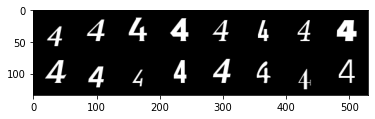

torch.Size([128, 1, 64, 64])


In [7]:
import PIL
import os
import pathlib

torch.manual_seed(42)

class FlatImageFolder(torch.utils.data.Dataset):
    def __init__(self, path, transform):
        self._path = pathlib.Path(path)
        self._transform = transform
        self._image_paths = list(self._path.iterdir())
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        with open(self._image_paths[idx], 'rb') as f:
            img = PIL.Image.open(f)
            img = img.convert("L")
            
            return self._transform(img)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(7),
#     transforms.Pad((3, 3, 4, 4)),
])

# train_dataset = FlatImageFolder("/data/datasets/fonts/rendered/numbers_small/4", transform)
train_dataset = FlatImageFolder("/data/datasets/fonts/rendered/numbers/4", transform)
print(f"Train dataset has {len(train_dataset)} examples")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10)
train_iter = iter(train_loader)
train_images = train_iter.next()

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
#     img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_images[:16]))
print(train_images.shape)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
    
# https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
# https://arxiv.org/pdf/1808.00362.pdf
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        
        self.encoder_linear = nn.Sequential(
            nn.LeakyReLU(.2), # what should be applied on the conv
            nn.Linear(256*2*2, 128),
            nn.LeakyReLU(.2),
            nn.Linear(128, 4),
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(4, 128),
            nn.LeakyReLU(.2),
            nn.Linear(128, 256*2*2),
            nn.LeakyReLU(.2),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, 256*2*2)
        x = self.encoder_linear(x)
        
        x = self.decoder_linear(x)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder_conv(x)
        return x

net = Autoencoder()
n = net(train_images)
print("Batch output shape:", n.shape)
print()

for i, p in enumerate(net.parameters()):
    print("Parameters", i, p.size())
print("Trainable parameters:", sum([p.numel() for p in net.parameters()]))

Batch output shape: torch.Size([128, 1, 64, 64])

Parameters 0 torch.Size([16, 1, 3, 3])
Parameters 1 torch.Size([16])
Parameters 2 torch.Size([32, 16, 3, 3])
Parameters 3 torch.Size([32])
Parameters 4 torch.Size([64, 32, 3, 3])
Parameters 5 torch.Size([64])
Parameters 6 torch.Size([128, 64, 3, 3])
Parameters 7 torch.Size([128])
Parameters 8 torch.Size([256, 128, 3, 3])
Parameters 9 torch.Size([256])
Parameters 10 torch.Size([128, 1024])
Parameters 11 torch.Size([128])
Parameters 12 torch.Size([4, 128])
Parameters 13 torch.Size([4])
Parameters 14 torch.Size([128, 4])
Parameters 15 torch.Size([128])
Parameters 16 torch.Size([1024, 128])
Parameters 17 torch.Size([1024])
Parameters 18 torch.Size([256, 128, 3, 3])
Parameters 19 torch.Size([128])
Parameters 20 torch.Size([128, 64, 3, 3])
Parameters 21 torch.Size([64])
Parameters 22 torch.Size([64, 32, 3, 3])
Parameters 23 torch.Size([32])
Parameters 24 torch.Size([32, 16, 3, 3])
Parameters 25 torch.Size([16])
Parameters 26 torch.Size([16, 1

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  net = nn.DataParallel(net)

net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Autoencoder(
    (encoder_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (encoder_linear): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=1024, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=4, bias=True)
    )
    (decoder_linear): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negati

In [10]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=.001)
# optimizer = optim.SGD(net.parameters(), lr=.001)

global_step = 0
for epoch in range(5):
    
    for train_minibatch, train_inputs in enumerate(train_loader):
        global_step += 1
        
        train_inputs = train_inputs.to(device)
        
        optimizer.zero_grad()
        train_outputs = net(train_inputs)
        train_loss = criterion(train_outputs, train_inputs)
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", train_loss.item(), global_step)
        
        with torch.no_grad():
            if global_step % 200 == 0:
                print("[Step {:5d}] train loss: {:0.4f}".format(global_step, train_loss.item()))
                
                writer.add_images("Images/train_inputs", train_inputs[:100], global_step)
                writer.add_images("Images/train_outputs", train_outputs[:100], global_step)
            
#                 # Now run through the full test dataset
#                 test_loss = 0
#                 test_total = 0
#                 test_correct = 0
#                 for test_minibatch, (test_inputs, test_labels) in enumerate(test_loader):
#                     test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

#                     test_outputs = net(test_inputs)
#                     test_loss += criterion(test_outputs, test_labels) * test_labels.size(0)

#                     _, test_predicted = torch.max(test_outputs.data, 1)
#                     test_total += test_labels.size(0)
#                     test_correct += (test_predicted == test_labels).sum().item()

#                 test_loss /= test_total
#                 test_accuracy = test_correct / test_total

#                 print("test loss: {:0.4f}, accuracy: {:0.3f} ({:3d} / {:3d})".format(
#                     test_loss, test_accuracy, test_correct, test_total
#                 ))
                
#                 writer.add_scalar("Loss/test", test_loss.item(), global_step)
#                 writer.add_scalar("Accuracy/test", test_accuracy, global_step)
#                 writer.add_images("Images/test", test_inputs[:100], global_step)
#                 writer.add_images("Images/train", train_inputs[:100], global_step)

writer.close()

            
print("Finished training!")

[Step   200] train loss: 0.0327
[Step   400] train loss: 0.0272
[Step   600] train loss: 0.0200
[Step   800] train loss: 0.0156
[Step  1000] train loss: 0.0137
[Step  1200] train loss: 0.0135
[Step  1400] train loss: 0.0128
[Step  1600] train loss: 0.0118
[Step  1800] train loss: 0.0106
[Step  2000] train loss: 0.0111
[Step  2200] train loss: 0.0105
[Step  2400] train loss: 0.0104
Finished training!
